# Generate summary statistics for figure 3.

In [58]:
# General dependencies
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pickle as pkl
import os
from math import isnan

In [2]:
# This is where to find the data
data_dir = "/Volumes/condor/lthomas/Projects/Thesis_analysis/STRF_SMRF_PKLs_2512"
# Read all the pkl files in the data directory
data_files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]

# THe file that has the information about unit types
histo_file = "/Volumes/condor/lthomas/Projects/Thesis_analysis/all_units_unit_types_260130.pkl"
with open(histo_file, 'rb') as infile:
    histoDF  = pkl.load(infile)

sites = np.unique(histoDF['site'])

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/4084998930.py:9: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  histoDF  = pkl.load(infile)


In [3]:
# Open one data file to check it out
file_path = os.path.join(data_dir, data_files[0])
with open(file_path, 'rb') as infile:
    dataFrame  = pkl.load(infile)
dataFrame.keys()

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/3590087964.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Index(['nwb_file_identifier', 'unit', 'r2Ceil', 'r2segModel', 'r2segIDModelLG',
       'r2segIDModelDG', 'r2segIDModelLGMPS', 'r2segIDModelDGMPS', 'r2STRF',
       'snr', 'f', 'snrEstf', 'cumInfo', 'totWeight', 'Laguerre_args',
       'dogs_args', 'pca_spect', 'pca_mps', 'strfModel', 'segModel',
       'segIDModelLG', 'segIDModelDG', 'segIDModelLGMPS', 'segIDModelDGMPS',
       'unit_id', 'error', 'nwb_file', 'bird'],
      dtype='object')

In [7]:
# Some rows have Nan?  Like row for unit_id 6 in this first file
for i, row in dataFrame.iterrows():
    if not isnan(row['snr']):
        print(row['nwb_file'], row['bird'], int(row['unit']), row['snr'], row['cumInfo'][-1])

XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 4 0.20320140862572209 12.854322601878135
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 5 0.29850280252344513 22.167637182193833
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 9 0.17277894870124805 16.187519792394898
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 11 0.08672545608805186 5.918552325438442
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 12 0.1466952034216828 7.080080433407732
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 13 0.053373375860158064 2.2277453692240137
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 18 0.3317059755697242 20.350909401328394
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 19 0.18818018625130725 5.427422546275835
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 21 0.15365924132517145 12.522597323744318
XXXLbl116XF_site2_251017_130550_op_pb_ks4_la

In [ ]:
bird = 'BlaBla3637M'
good_site = 'BlaBla3736M_d2_240815_152202'   #  Note the name of the bird in site is different
unit = 0
# unit_type_row = histoDF[(histoDF['site'] == good_site) & (histoDF['unit_id'] == unit) & (histoDF['bird'] == bird)]
unit_type_row = histoDF[ (histoDF['bird'] == bird)]
print(unit_type_row['unit_id'].iloc[0], unit_type_row['unit_type'].iloc[0])

0 bs


In [ ]:
# Store all the data in numpy arrays

snrs = []
infos = []
units = []
birds = []
nwbFiles = []
rate = []
data_length = []
r2Ceils = []
r2Segs = []
r2segIds = []
r2STRFs = []
unit_types = []
cumInfoWindow = 4  # Number of points to consider for plateau detection to correct for high-frequency noise in coherence based information.  


for f in data_files:
    file_path = os.path.join(data_dir, f)
    with open(file_path, 'rb') as infile:
        dataFrame  = pkl.load(infile)
    
    for i, row in dataFrame.iterrows():
        if not isnan(row['snr']):
            snrs.append(row['snr'])
            # Find first plateau value in cumInfo
            cumInfo = row['cumInfo']
            
            plateau_start = -1
            foundZero = False
            for i in range(1, len(cumInfo) - cumInfoWindow):
                if cumInfo[i] == cumInfo[i-1]:  # If zero change assume plateau
                    if not foundZero:
                        plateau_start = i-1
                        foundZero = True
                    if i - plateau_start == cumInfoWindow:  # Found platueau
                        # print(f"Found plateau for unit {row['unit']} at index {plateau_start} with value {cumInfo[plateau_start]} instead of {cumInfo[-1]}")
                        break
                else:
                    plateau_start = -1  # Reset if non-zero found
                    foundZero = False
            infos.append(cumInfo[plateau_start])   # Take the value of the plateau.

            units.append(int(row['unit']))
            birds.append(row['bird'])  
            rate.append(row['segModel']['yavg'])
            data_length.append(row['totWeight'])
            nwbFiles.append(row['nwb_file'])
            r2Ceils.append(row['r2Ceil'])
            r2Segs.append(row['r2segModel'])
            r2segIds.append(row['r2segIDModelLG'])
            r2STRFs.append(row['r2STRF'])

            site_info = row['nwb_file']
            good_site = None
            for site in sites:
                if site in row['nwb_file']:
                    good_site = site
                    break
            bird = row['bird']
            #   Fix bird if 'BlaBla3637M'
            if bird == 'BlaBla3736M':
                bird = 'BlaBla3637M'
            site_unit_info = histoDF[(histoDF['site'] == good_site)  & (histoDF['bird'] == bird)]
            if len(site_unit_info) == 0:
                print(f"Site info not found for bird {row['bird']}, site {good_site}")
            else:
                unit_type_row = histoDF[(histoDF['site'] == good_site) & (histoDF['unit_id'] == row['unit']) & (histoDF['bird'] == bird)]
                if len(unit_type_row) == 1:
                    unit_types.append(unit_type_row['unit_type'].iloc[0])
                else:
                    print(f"Unit type not found for bird {row['bird']}, site {good_site}, unit {row['unit']}")
                    unit_types.append('un')

snrs = np.array(snrs)
infos = np.array(infos)
rate = np.array(rate)
data_length = np.array(data_length) 
r2Ceils = np.array(r2Ceils)
r2Segs = np.array(r2Segs)
r2segIds = np.array(r2segIds)
r2STRFs = np.array(r2STRFs)
units = np.array(units, dtype=int)
birds = np.array(birds)
nwbFiles = np.array(nwbFiles)
unit_types = np.array(unit_types)

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/831360522.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Found plateau for unit 4.0 at index 29 with value 12.684314669957256 instead of 12.854322601878135
Found plateau for unit 5.0 at index 56 with value 22.036894824263932 instead of 22.167637182193833
Found plateau for unit 9.0 at index 43 with value 15.917796753047712 instead of 16.187519792394898
Found plateau for unit 11.0 at index 28 with value 4.937354206581101 instead of 5.918552325438442
Found plateau for unit 12.0 at index 13 with value 6.818159866732486 instead of 7.080080433407732
Found plateau for unit 13.0 at index 17 with value 1.950620005044018 instead of 2.2277453692240137
Found plateau for unit 18.0 at index 31 with value 20.14823283094207 instead of 20.350909401328394
Found plateau for unit 19.0 at index 12 with value 4.887241534786878 instead of 5.427422546275835
Found plateau for unit 21.0 at index 34 with value 11.929947952586657 instead of 12.522597323744318
Found plateau for unit 23.0 at index 26 with value 7.784799134507594 instead of 8.2264452449781
Found plateau f

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/831360522.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Found plateau for unit 1.0 at index 0 with value 0.0 instead of 0.7175097211875417
Found plateau for unit 3.0 at index 1 with value 1.5467882217632307 instead of 2.563938048678142
Found plateau for unit 5.0 at index 3 with value 0.6712614696277744 instead of 1.4232049923266177
Found plateau for unit 7.0 at index 7 with value 2.432692714468862 instead of 2.6210427026368195
Found plateau for unit 8.0 at index 0 with value 0.09856431338666913 instead of 0.8395630628879309
Found plateau for unit 12.0 at index 8 with value 7.483117093122126 instead of 7.669603106881602
Found plateau for unit 14.0 at index 0 with value 0.0 instead of 0.0
Found plateau for unit 15.0 at index 0 with value 0.371465191717328 instead of 4.848171897921904
Found plateau for unit 19.0 at index 6 with value 4.684215941883963 instead of 4.890114016891021
Found plateau for unit 20.0 at index 1 with value 0.37927129941766724 instead of 3.7178535310849288
Found plateau for unit 21.0 at index 2 with value 3.07258097531047

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/831360522.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Found plateau for unit 0.0 at index 5 with value 9.916681119286585 instead of 10.949327474151444
Found plateau for unit 2.0 at index 7 with value 10.428879512755673 instead of 10.910902440224659
Found plateau for unit 4.0 at index 2 with value 1.3084964450405485 instead of 2.2633431328009976
Found plateau for unit 9.0 at index 4 with value 3.6017172309464343 instead of 4.225035889249184
Found plateau for unit 10.0 at index 3 with value 2.9429324196590567 instead of 5.925878756840053
Found plateau for unit 11.0 at index 0 with value 0.4266503955952481 instead of 3.4473474295541946
Found plateau for unit 12.0 at index 2 with value 6.259635436256483 instead of 9.255471690683136
Found plateau for unit 16.0 at index 11 with value 7.56345310349192 instead of 8.605895914625597
Found plateau for unit 19.0 at index 5 with value 6.107114159349762 instead of 7.432418702032824
Found plateau for unit 20.0 at index 7 with value 11.499584649659797 instead of 12.143000887489329
Found plateau for unit 

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/831360522.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Found plateau for unit 4.0 at index 10 with value 6.003343849350234 instead of 6.910685413785496
Found plateau for unit 6.0 at index 9 with value 6.272569739747808 instead of 7.068745714549848
Found plateau for unit 8.0 at index 4 with value 4.489429999983926 instead of 4.861530659694505
Found plateau for unit 10.0 at index 12 with value 3.5691966647611704 instead of 5.026998112740026
Found plateau for unit 11.0 at index 7 with value 7.967803943105212 instead of 8.189576295608415
Found plateau for unit 13.0 at index 10 with value 8.657435611047452 instead of 9.023722996916225
Found plateau for unit 17.0 at index 16 with value 9.309229138241244 instead of 12.620397427970731
Found plateau for unit 18.0 at index 6 with value 3.278498404409219 instead of 3.4758440629549194
Found plateau for unit 19.0 at index 10 with value 8.036527937807634 instead of 8.652080792880854
Found plateau for unit 21.0 at index 13 with value 8.130569506869744 instead of 8.679722687954559
Found plateau for unit 2

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/831360522.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Found plateau for unit 7.0 at index 56 with value 25.417863079014808 instead of 25.62909699001426
Found plateau for unit 17.0 at index 4 with value 2.3422791115281543 instead of 2.89036588063641
Found plateau for unit 23.0 at index 3 with value 0.23752100731904743 instead of 0.9098376480505314
Found plateau for unit 24.0 at index 6 with value 0.6197863373829846 instead of 0.9566213115743475
Found plateau for unit 25.0 at index 14 with value 5.389498631285164 instead of 6.390249418278475
Found plateau for unit 26.0 at index 9 with value 1.410275223205842 instead of 1.7148821400245018
Found plateau for unit 28.0 at index 17 with value 8.837369808892051 instead of 9.43559401878597
Found plateau for unit 31.0 at index 3 with value 2.717054435248366 instead of 3.7058485203684084
Found plateau for unit 32.0 at index 20 with value 5.203716528335163 instead of 5.7374461558445065
Found plateau for unit 33.0 at index 9 with value 2.3340386363074623 instead of 2.7334363229374223
Found plateau for

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/831360522.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Found plateau for unit 0.0 at index 5 with value 4.194664487484658 instead of 4.510456559165858
Found plateau for unit 1.0 at index 7 with value 5.545015879941202 instead of 6.82396601744103
Found plateau for unit 2.0 at index 0 with value 0.9193072974859768 instead of 5.014799947720653
Found plateau for unit 3.0 at index 4 with value 0.4703424711651485 instead of 1.9095924567106672
Found plateau for unit 6.0 at index 10 with value 9.253517606240871 instead of 9.703418233362852
Found plateau for unit 8.0 at index 1 with value 0.5882937246317658 instead of 1.1065020060487798
Found plateau for unit 9.0 at index 5 with value 3.390552167272481 instead of 4.70531654208699
Found plateau for unit 10.0 at index 1 with value 1.0948170373603192 instead of 2.1096176602800507
Found plateau for unit 11.0 at index 14 with value 22.438489734111947 instead of 24.94513722653614
Found plateau for unit 12.0 at index 10 with value 6.640026847814156 instead of 6.975329600210227
Found plateau for unit 13.0 

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/831360522.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Found plateau for unit 0.0 at index 7 with value 1.9627499498820933 instead of 2.318387871220104
Found plateau for unit 1.0 at index 12 with value 8.817241006644862 instead of 9.04297032618866
Found plateau for unit 2.0 at index 13 with value 9.657964544266132 instead of 9.970658539440409
Found plateau for unit 3.0 at index 19 with value 19.735843317502408 instead of 20.124976207171052
Found plateau for unit 4.0 at index 10 with value 0.859003234963853 instead of 1.0776248086415994
Found plateau for unit 5.0 at index 13 with value 6.011806970105566 instead of 6.348232358744672
Found plateau for unit 7.0 at index 12 with value 3.0135444327841805 instead of 3.485231945872196
Found plateau for unit 8.0 at index 14 with value 7.5261043183595255 instead of 8.012717948327637
Found plateau for unit 9.0 at index 10 with value 10.082676613386997 instead of 10.237799274104027
Found plateau for unit 10.0 at index 4 with value 0.1709769053679152 instead of 0.3914288380517407
Found plateau for unit

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/831360522.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Found plateau for unit 3.0 at index 5 with value 9.989914884519813 instead of 10.104172463462671
Found plateau for unit 4.0 at index 7 with value 4.46946712476525 instead of 6.600971683187847
Found plateau for unit 5.0 at index 0 with value 0.6969990894069722 instead of 3.641491283989637
Found plateau for unit 6.0 at index 19 with value 25.123196899340652 instead of 25.59310970075578
Found plateau for unit 7.0 at index 3 with value 3.4783259387111753 instead of 5.071377917411893
Found plateau for unit 8.0 at index 5 with value 5.8064233642083645 instead of 7.062728388145335
Found plateau for unit 9.0 at index 3 with value 3.9992793163881175 instead of 4.651582562770446
Found plateau for unit 10.0 at index 4 with value 2.0657861254067083 instead of 3.9998128877622707
Found plateau for unit 11.0 at index 5 with value 9.419543395206132 instead of 9.858210980563435
Found plateau for unit 12.0 at index 6 with value 5.633038471405101 instead of 6.125182950191384
Found plateau for unit 13.0 a

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/831360522.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Found plateau for unit 85 at index 7 with value 9.389423138872859 instead of 9.922095609081534
Found plateau for unit 86 at index 3 with value 3.003103052583207 instead of 4.30691116899308
Found plateau for unit 88 at index 8 with value 8.812699712905056 instead of 9.411806633721698
Found plateau for unit 89 at index 7 with value 10.307850169861675 instead of 10.70822338736443
Found plateau for unit 2 at index 4 with value 5.087594042306013 instead of 5.505609097783164
Found plateau for unit 3 at index 6 with value 4.088953523664826 instead of 4.509226642354237
Found plateau for unit 4 at index 4 with value 6.910362665273543 instead of 7.2895715711976665
Found plateau for unit 5 at index 17 with value 19.140770251172512 instead of 19.43321883866016
Found plateau for unit 8 at index 6 with value 10.692076536147006 instead of 11.1702850285172
Found plateau for unit 11 at index 5 with value 3.60508109249069 instead of 3.9234395726734705
Found plateau for unit 13 at index 6 with value 9.80

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/831360522.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Found plateau for unit 2.0 at index 33 with value 24.27800623339222 instead of 24.691606608738326
Found plateau for unit 4.0 at index 36 with value 19.311653218464336 instead of 19.49698744894933
Found plateau for unit 5.0 at index 40 with value 23.966410252291716 instead of 24.3110521333115
Found plateau for unit 7.0 at index 26 with value 25.374183001222992 instead of 25.686682925727414
Found plateau for unit 12.0 at index 30 with value 18.272431843732605 instead of 18.5267909389856
Found plateau for unit 13.0 at index 13 with value 5.219251994140521 instead of 5.583845425477198
Found plateau for unit 15.0 at index 36 with value 12.68838657634701 instead of 13.199454543507946
Found plateau for unit 16.0 at index 40 with value 18.23687636338914 instead of 18.370259713918742
Found plateau for unit 17.0 at index 27 with value 16.00731712821131 instead of 16.170036678285562
Found plateau for unit 18.0 at index 31 with value 9.07906286666942 instead of 9.366231397531488
Found plateau for 

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/831360522.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Found plateau for unit 0.0 at index 6 with value 11.74990425812294 instead of 13.78189507790848
Found plateau for unit 2.0 at index 5 with value 8.450167299950344 instead of 9.393695724617357
Found plateau for unit 3.0 at index 1 with value 0.6032277698237738 instead of 1.2727884828660028
Found plateau for unit 4.0 at index 4 with value 8.199065200149992 instead of 9.28553745329705
Found plateau for unit 6.0 at index 9 with value 13.417954707203778 instead of 13.976201065995129
Found plateau for unit 7.0 at index 4 with value 2.5754619006007817 instead of 4.463407847605936
Found plateau for unit 8.0 at index 6 with value 7.938788544917534 instead of 8.490627449878751
Found plateau for unit 9.0 at index 5 with value 6.3849204527803485 instead of 6.798625549908623
Found plateau for unit 11.0 at index 8 with value 9.525349718716006 instead of 10.855502173453749
Found plateau for unit 13.0 at index 5 with value 10.919650545876966 instead of 12.32224998096053
Found plateau for unit 14.0 at 

## Choosing Auditory vs Non-Auditory Units
We will chose auditory units based on thresholds of coherence, evoked rate and data size.

Number of units with SNR > 0.0 and Information > 6.0 and Rate > 1.0 and Data Size > 1000: 526/1367


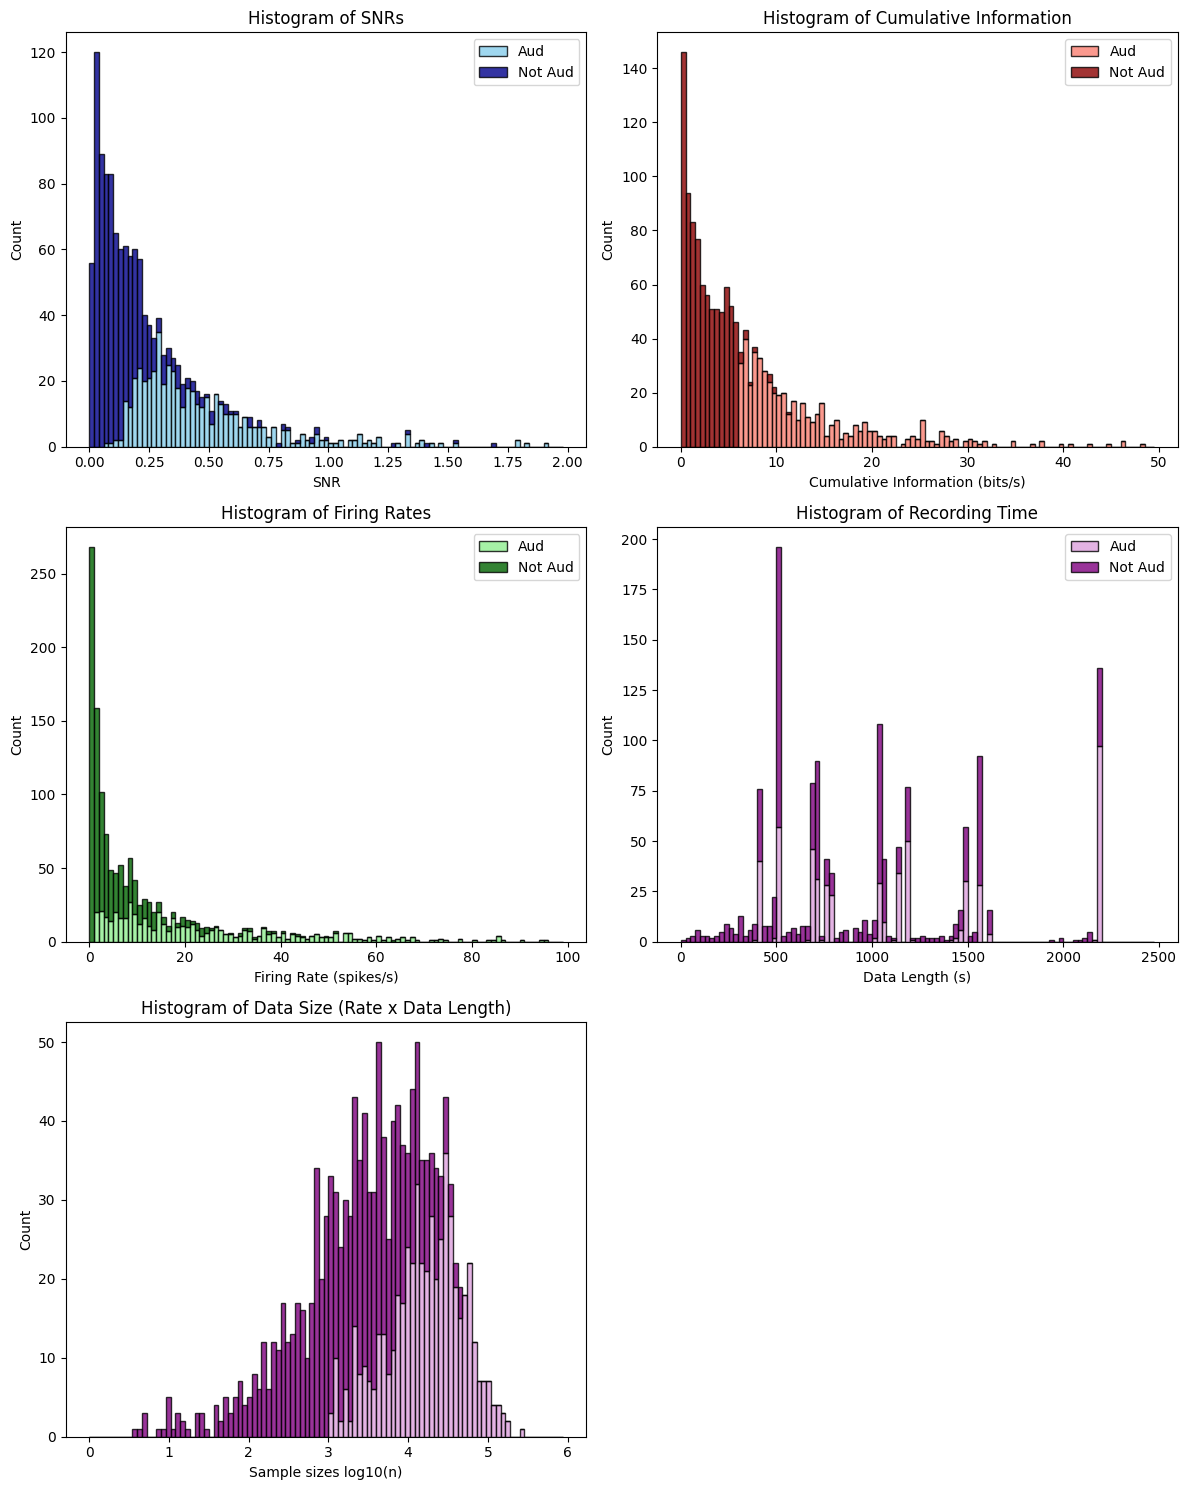

In [47]:
# Plot histograms
# We need to figure out thresholds for auditory units.  I propose this:

information_threshold = 6.0 # in bits/s
snr_threshold = 0.0 # unitless
rate_threshold = 1.0 # average evoked rate in spikes/s
data_size_threshold = 1000 # Requiring at leat 1000 spikes.

idx = (snrs > snr_threshold) & (infos > information_threshold) & (rate > rate_threshold) & (rate*data_length/1000 > data_size_threshold)
print(f"Number of units with SNR > {snr_threshold} and Information > {information_threshold} and Rate > {rate_threshold} and Data Size > {data_size_threshold}: {np.sum(idx)}/{len(snrs)}")

# Histograms of all parameters
plt.figure(figsize=(12, 15))

# Histogram of SNRs
plt.subplot(3, 2, 1)
bins = np.arange(0, 2.0, 2.0/100)
list_of_data = [snrs[idx], snrs[~idx]]
labels = ['Aud', 'Not Aud']
colors = ['skyblue', 'darkblue']
plt.hist(list_of_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='black', alpha=0.8)
plt.title('Histogram of SNRs')
plt.legend()
plt.xlabel('SNR')
plt.ylabel('Count')


# Histogram of cumulative information
plt.subplot(3, 2, 2)
bins = np.arange(0, 50, 50/100)
list_of_data = [infos[idx], infos[~idx]]
labels = ['Aud', 'Not Aud']
colors = ['salmon', 'darkred']
plt.hist(list_of_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='black', alpha=0.8)
plt.title('Histogram of Cumulative Information')
plt.legend()
plt.xlabel('Cumulative Information (bits/s)')
plt.ylabel('Count')

# Histogram of firing rates
plt.subplot(3, 2, 3)
bins = np.arange(0, 100.0, 100.0/100)
list_of_data = [rate[idx], rate[~idx]]
labels = ['Aud', 'Not Aud']
colors = ['lightgreen', 'darkgreen']
plt.hist(list_of_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='black', alpha=0.8)
plt.title('Histogram of Firing Rates')
plt.legend()
plt.xlabel('Firing Rate (spikes/s)')
plt.ylabel('Count')

# Histogram of recording time
plt.subplot(3, 2, 4)
bins = np.arange(0, 2500.0, 2500.0/100)
list_of_data = [data_length[idx]/1000, data_length[~idx]/1000]
labels = ['Aud', 'Not Aud']
colors = ['plum', 'purple']
plt.hist(list_of_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='black', alpha=0.8 )
plt.title('Histogram of Recording Time')
plt.legend()
plt.xlabel('Data Length (s)')
plt.ylabel('Count')

# Histogram of data size (rate x data length)
plt.subplot(3, 2, 5)
bins = np.arange(0, 6.0, 6.0/100)
list_of_data = [np.log10(rate[idx]*data_length[idx]/1000), np.log10(rate[~idx]*data_length[~idx]/1000)]
labels = ['Aud', 'Not Aud']
colors = ['plum', 'purple']
plt.hist(list_of_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='black', alpha=0.8 )
plt.title('Histogram of Data Size (Rate x Data Length)')
plt.legend
plt.xlabel('Sample sizes log10(n)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




## Differences in information and rates between NS and BS neuros

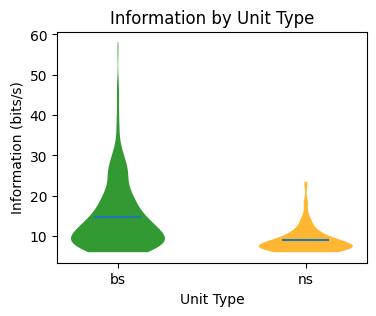

Mean Information for bs: 14.73 +- 0.409, ns: 9.01 +- 0.318
T-test between unit types bs and ns: t-statistic = 11.006, p-value = 5.09e-25


In [67]:
# Make a violin plot of cumulative information by unit type
unit_type_labels = ['bs', 'ns']
data_to_plot = [infos[(unit_types == ut) & idx] for ut in unit_type_labels] 
plt.figure(figsize=(4, 3))
parts = plt.violinplot(data_to_plot, showmeans=True, showextrema=False)
parts['bodies'][0].set_facecolor('green')
parts['bodies'][1].set_facecolor('orange')
parts['bodies'][0].set_alpha(0.8)
parts['bodies'][1].set_alpha(0.8)
plt.xticks([1, 2], unit_type_labels)
plt.title('Information by Unit Type')
plt.xlabel('Unit Type')
plt.ylabel('Information (bits/s)')
plt.show()

t_stat, p_val = stats.ttest_ind(data_to_plot[0], data_to_plot[1], equal_var=False)
print(f"Mean Information for bs: {np.mean(data_to_plot[0]):.2f} +- {np.std(data_to_plot[0])/np.sqrt(len(data_to_plot[0])):.3f}, ns: {np.mean(data_to_plot[1]):.2f} +- {np.std(data_to_plot[1])/np.sqrt(len(data_to_plot[1])):.3f}")
print(f"T-test between unit types bs and ns: t-statistic = {t_stat:.3f}, p-value = {p_val:.3g}")

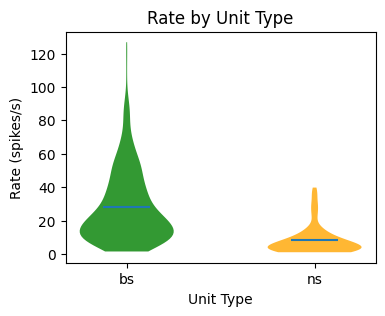

Mean Rate for bs: 28.13 +- 1.055, ns: 8.08 +- 0.828
T-test between unit types bs and ns: t-statistic = 14.910, p-value = 7.6e-41


In [65]:
# Make a violin plot of rate by unit type
unit_type_labels = ['bs', 'ns']
data_to_plot = [rate[(unit_types == ut) & idx] for ut in unit_type_labels] 
plt.figure(figsize=(4, 3))
parts = plt.violinplot(data_to_plot, showmeans=True, showextrema=False)
parts['bodies'][0].set_facecolor('green')
parts['bodies'][1].set_facecolor('orange')
parts['bodies'][0].set_alpha(0.8)
parts['bodies'][1].set_alpha(0.8)
plt.xticks([1, 2], unit_type_labels)
plt.title('Rate by Unit Type')
plt.xlabel('Unit Type')
plt.ylabel('Rate (spikes/s)')
plt.show()

t_stat, p_val = stats.ttest_ind(data_to_plot[0], data_to_plot[1], equal_var=False)
print(f"Mean Rate for bs: {np.mean(data_to_plot[0]):.2f} +- {np.std(data_to_plot[0])/np.sqrt(len(data_to_plot[0])):.3f}, ns: {np.mean(data_to_plot[1]):.2f} +- {np.std(data_to_plot[1])/np.sqrt(len(data_to_plot[1])):.3f}")
print(f"T-test between unit types bs and ns: t-statistic = {t_stat:.3f}, p-value = {p_val:.3g}")

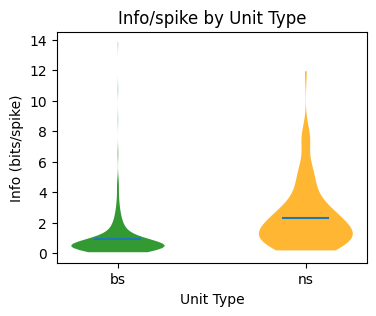

Mean Info/spike for bs: 0.93 +- 0.061, ns: 2.34 +- 0.200
T-test between unit types bs and ns: t-statistic = -6.667, p-value = 7.69e-10


In [64]:
# Make a violin plot of bits/spike by unit type
unit_type_labels = ['bs', 'ns']
data_to_plot = [infos[(unit_types == ut) & idx]/rate[(unit_types == ut) & idx] for ut in unit_type_labels] 
plt.figure(figsize=(4, 3))
parts = plt.violinplot(data_to_plot, showmeans=True, showextrema=False)
parts['bodies'][0].set_facecolor('green')
parts['bodies'][1].set_facecolor('orange')
parts['bodies'][0].set_alpha(0.8)
parts['bodies'][1].set_alpha(0.8)
plt.xticks([1, 2], unit_type_labels)
plt.title('Info/spike by Unit Type')
plt.xlabel('Unit Type')
plt.ylabel('Info (bits/spike)')
plt.show()

t_stat, p_val = stats.ttest_ind(data_to_plot[0], data_to_plot[1], equal_var=False)
print(f"Mean Info/spike for bs: {np.mean(data_to_plot[0]):.2f} +- {np.std(data_to_plot[0])/np.sqrt(len(data_to_plot[0])):.3f}, ns: {np.mean(data_to_plot[1]):.2f} +- {np.std(data_to_plot[1])/np.sqrt(len(data_to_plot[1])):.3f}")
print(f"T-test between unit types bs and ns: t-statistic = {t_stat:.3f}, p-value = {p_val:.3g}")

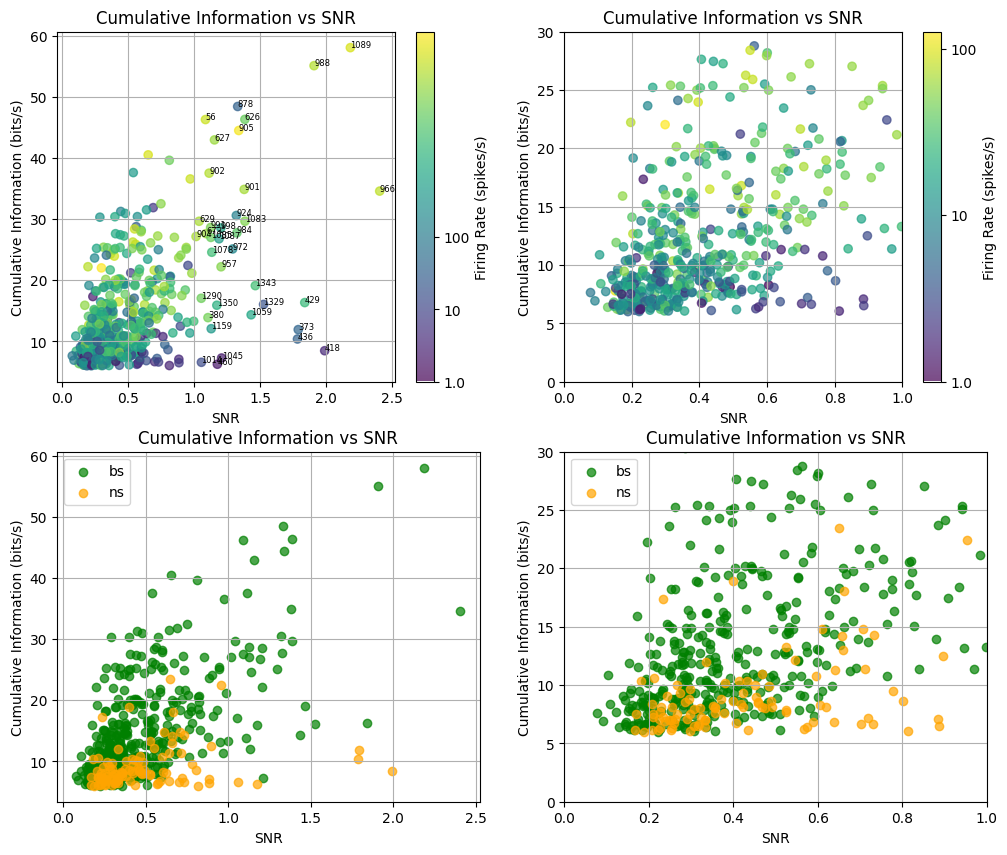

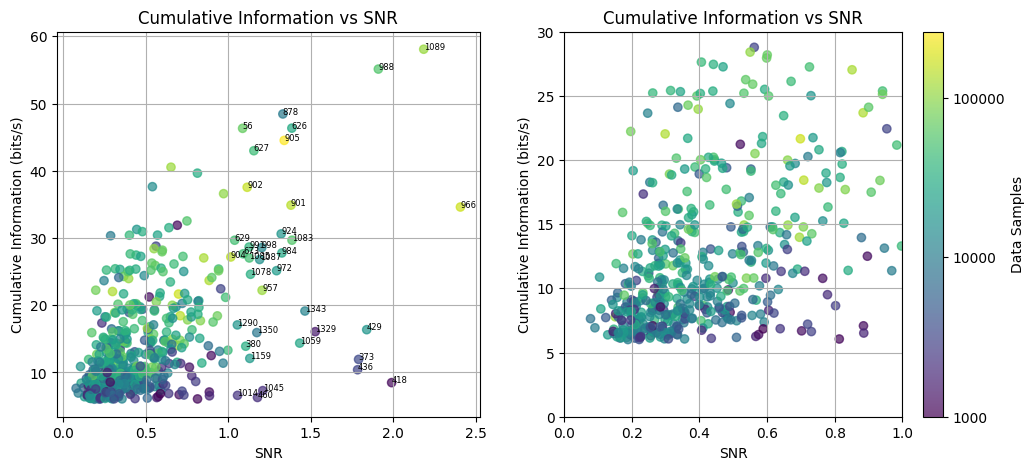

In [50]:
# Scatter plot of cumulative information vs SNR colored by rate

plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.scatter(snrs[idx], infos[idx], c = np.log(rate[idx]), cmap ='viridis', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlabel('SNR')
plt.ylabel('Cumulative Information (bits/s)')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.grid(True)
# Add text labels for snr> 1
for i, snr in enumerate(snrs):
    if idx[i] and snr > 1.0:
        plt.text(snrs[i], infos[i], f"{i}", fontsize=6)

# Zoome in on low SNR region
plt.subplot(2,2,2)
plt.scatter(snrs[idx], infos[idx], c = np.log10(rate[idx]), cmap ='viridis', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlim((0.0, 1.0))
plt.xlabel('SNR')
plt.ylim((0.0, 30.0))
plt.ylabel('Cumulative Information (bits/s)')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.grid(True)

# Repeat using unit_types for color
bs_idx = idx & (unit_types == 'bs')
ns_idx = idx & (unit_types == 'ns')
plt.subplot(2,2,3)
plt.scatter(snrs[bs_idx], infos[bs_idx], c = 'green', label='bs', alpha=0.7)
plt.scatter(snrs[ns_idx], infos[ns_idx], c = 'orange', label='ns', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlabel('SNR')
plt.ylabel('Cumulative Information (bits/s)')
plt.legend()
plt.grid(True)

# Zoom in on low SNR region
plt.subplot(2,2,4)
plt.scatter(snrs[bs_idx], infos[bs_idx], c = 'green', label='bs', alpha=0.7)
plt.scatter(snrs[ns_idx], infos[ns_idx], c = 'orange', label='ns', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlim((0.0, 1.0))
plt.xlabel('SNR')
plt.ylim((0.0, 30.0))
plt.ylabel('Cumulative Information (bits/s)')
plt.legend()
plt.grid(True)

plt.show()

# Scatter plot of cumulative information vs SNR colored by square root total data 

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(snrs[idx], infos[idx], c = np.log10(rate[idx]*data_length[idx]/1000), cmap ='viridis', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlabel('SNR')
plt.ylabel('Cumulative Information (bits/s)')
plt.grid(True)
# Add text labels for snr> 1
for i, snr in enumerate(snrs):
    if idx[i] and snr > 1.0:
        plt.text(snrs[i], infos[i], f"{i}", fontsize=6)
plt.subplot(1,2,2)
plt.scatter(snrs[idx], infos[idx], c = np.log10(rate[idx]*data_length[idx]/1000), cmap ='viridis', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlim((0.0, 1.0))
plt.xlabel('SNR')
plt.ylim((0.0, 30.0))
plt.ylabel('Cumulative Information (bits/s)')
cbar = plt.colorbar(label='Data Samples')
tickvalues = cbar.get_ticks()
cbar.set_ticks([3.0, 4.0, 5.0])
cbar.set_ticklabels([1000, 10000, 100000])
plt.grid(True)

plt.show()

In [32]:
units_to_label = [1014, 1045]

for i_unit in units_to_label:
        print(f"Unit {i_unit} found in Bird {birds[i_unit]} - Unit {units[i_unit]} - File: {nwbFiles[i_unit]}: SNR={snrs[i_unit]}, Info={infos[i_unit]}, Rate={rate[i_unit]}, Data Length={data_length[i_unit]/1000} s")

Unit 1014 found in Bird HpiPur2667F - Unit 85 - File: HpiPur2667F_site03_240905_133829_pb_op_ks4_lat_250215: SNR=1.0560268414686038, Info=6.587551061004611, Rate=3.051791039660453, Data Length=762.926 s
Unit 1045 found in Bird BlaBla3736M - Unit 29 - File: BlaBla3736M_d4_240816_144048_ks4_lat_250416: SNR=1.2089784242617583, Info=7.290603870902894, Rate=1.4632716982106289, Data Length=1448.12 s


/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/495951639.py:11: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

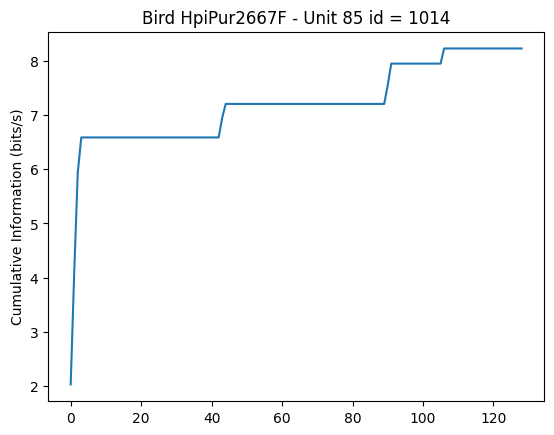

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/495951639.py:11: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Unit 1014 found in Bird HpiPur2667F - Unit 85: SNR=1.0560268414686038, Info=6.587551061004611, Rate=3.051791039660453, Data size=2328.2907307239907 spikes


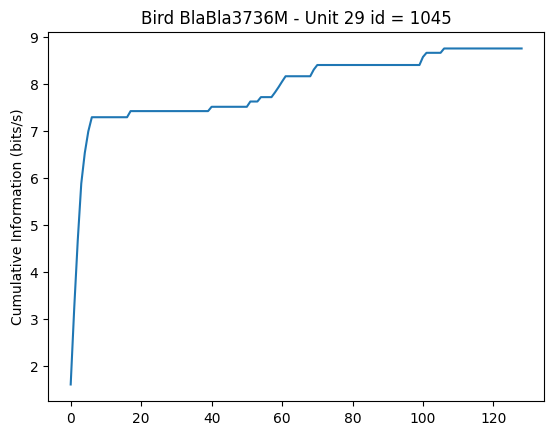

Unit 1045 found in Bird BlaBla3736M - Unit 29: SNR=1.2089784242617583, Info=7.290603870902894, Rate=1.4632716982106289, Data size=2118.9930116127757 spikes


In [34]:
# Plot the information for these neurons

for i_unit in units_to_label:
        bird  = birds[i_unit]
        unit = units[i_unit]

        # Read that data file and get the row. 
       
        file_path = os.path.join(data_dir, bird + '_' + nwbFiles[i_unit] + '_results.pkl')
        with open(file_path, 'rb') as infile:
                dataFrame  = pkl.load(infile)
        for i, row in dataFrame.iterrows():
                if row['unit'] == unit:
                        plt.figure()
                        plt.plot(row['cumInfo'])
                        plt.title(f'Bird {bird} - Unit {unit} id = {i_unit}') 
                        plt.ylabel('Cumulative Information (bits/s)')
                        plt.show()
                        print(f"Unit {i_unit} found in Bird {birds[i_unit]} - Unit {units[i_unit]}: SNR={snrs[i_unit]}, Info={infos[i_unit]}, Rate={rate[i_unit]}, Data size={rate[i_unit]*data_length[i_unit]/1000} spikes")
                        break



/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_37533/4135485916.py:32: RuntimeWarning: divide by zero encountered in divide
  idx_model = idx & (r2Segs/r2Ceils > r2_threshold)


Number of units with good models (R2 (corrected) > 0.05): 367/526


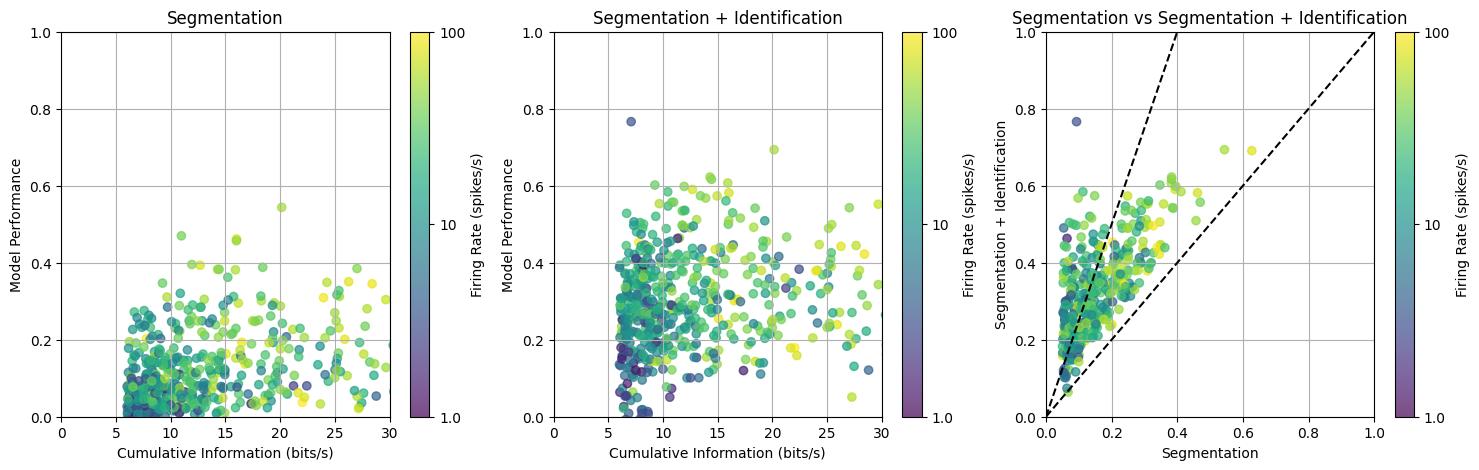

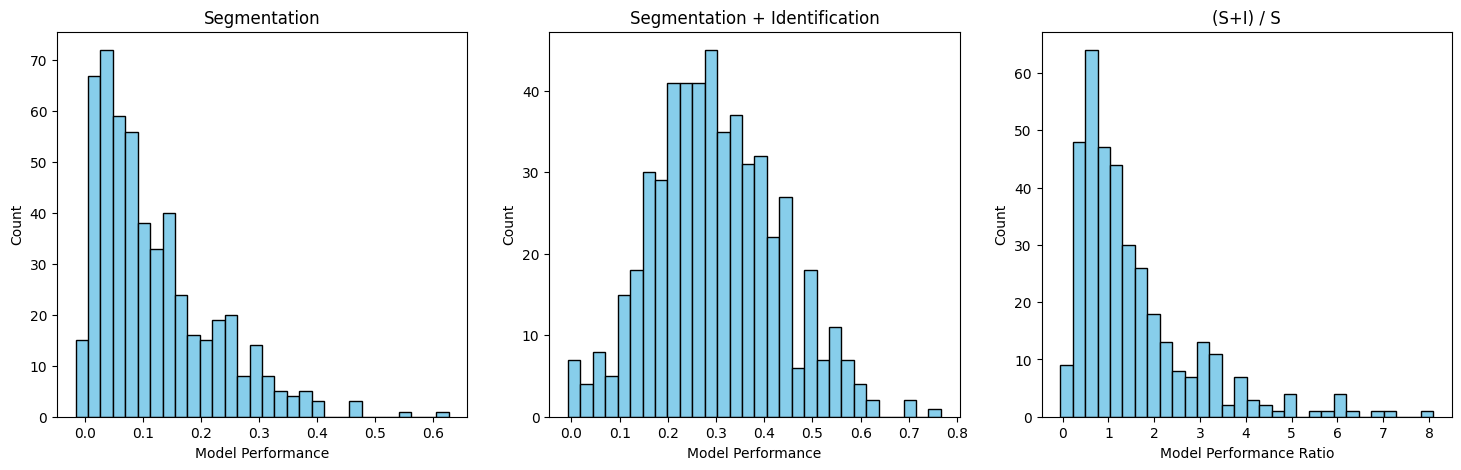

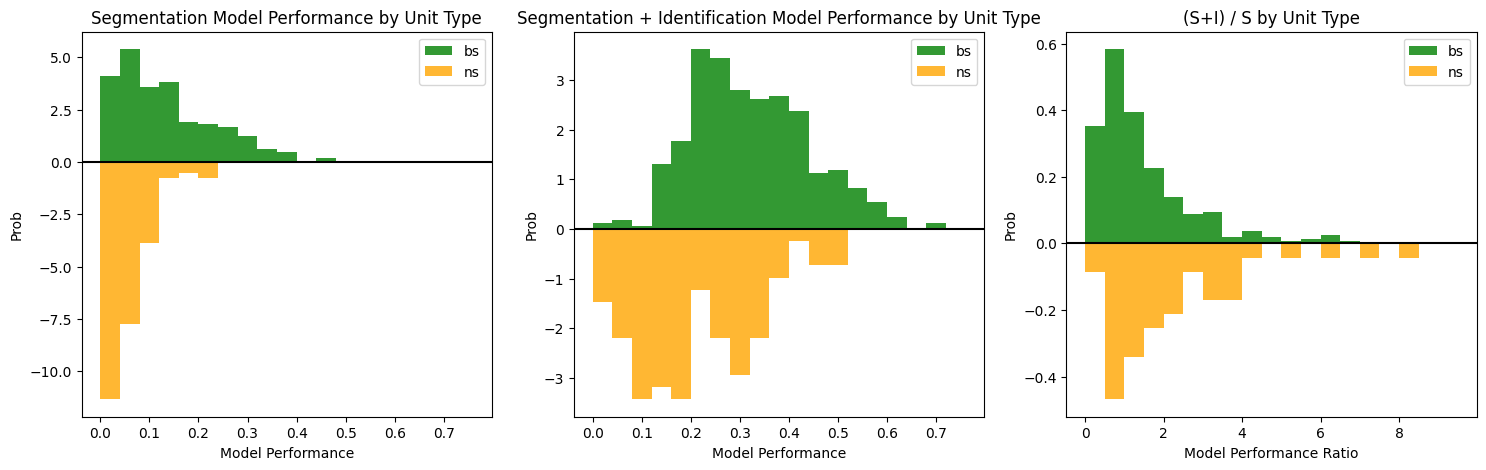

In [79]:
# Make scatter plots of model performance vs information

plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
plt.scatter(infos[idx], r2Segs[idx]/r2Ceils[idx], c = np.log10(rate[idx]), cmap ='viridis', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.title('Segmentation')
plt.xlabel('Cumulative Information (bits/s)')
plt.ylabel('Model Performance')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.xlim((0.0, 30.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.subplot(1,3,2)
plt.scatter(infos[idx], r2segIds[idx]/r2Ceils[idx], c = np.log10(rate[idx]), cmap ='viridis', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.title('Segmentation + Identification')
plt.xlabel('Cumulative Information (bits/s)')
plt.ylabel('Model Performance')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.xlim((0.0, 30.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

# Units predicted by encoding model
r2_threshold = 0.05
idx_model = idx & (r2Segs/r2Ceils > r2_threshold)
print(f"Number of units with good models (R2 (corrected) > {r2_threshold}): {np.sum(idx_model)}/{np.sum(idx)}")

plt.subplot(1,3,3)
plt.scatter(r2Segs[idx_model]/r2Ceils[idx_model], r2segIds[idx_model]/r2Ceils[idx_model], c = np.log10(rate[idx_model]), cmap ='viridis', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [0, 2.5], 'k--')
plt.title('Segmentation vs Segmentation + Identification')
plt.xlabel('Segmentation')
plt.ylabel('Segmentation + Identification')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.show()

# Histograms of model performance

plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
plt.hist(r2Segs[idx]/r2Ceils[idx], bins=30, color='skyblue', edgecolor='black')
plt.title('Segmentation')
plt.xlabel('Model Performance')
plt.ylabel('Count')

plt.subplot(1,3,2)
plt.hist(r2segIds[idx]/r2Ceils[idx], bins=30, color='skyblue', edgecolor='black')
plt.title('Segmentation + Identification')
plt.xlabel('Model Performance')
plt.ylabel('Count')

plt.subplot(1,3,3)
plt.hist((r2segIds[idx_model]-r2Segs[idx_model])/r2Segs[idx_model], bins=30, color='skyblue', edgecolor='black')
plt.title('(S+I) / S')
plt.xlabel('Model Performance Ratio')
plt.ylabel('Count')


plt.show()

# Histograms of model performance stacked by unit type
plt.figure(figsize=(18, 5))
ax = plt.subplot(1,3,1)
bins = np.arange(0, 0.8, 0.8/20)
idx_bs = idx & (unit_types == 'bs')
idx_ns = idx & (unit_types == 'ns')
list_of_data = [r2Segs[idx_bs]/r2Ceils[idx_bs], r2Segs[idx_ns]/r2Ceils[idx_ns]]
labels = ['bs', 'ns']
colors = ['green', 'orange']
ax.hist(list_of_data[0], bins=bins, density = True, stacked=False, label=labels[0], color=colors[0], alpha=0.8)
# freq, bins, patches = ax.hist(list_of_data[1], bins=bins, weights=-np.ones_like(list_of_data[1]), density = True, stacked=False, label=labels[1], color=colors[1], alpha=0.8)
freq, bins = np.histogram(list_of_data[1], bins=bins, density = True)
ax.bar(bins[:-1], -freq, width=np.diff(bins), align='edge', color=colors[1], alpha=0.8, label=labels[1])
ax.axhline(0, color="k")
plt.legend()
plt.title('Segmentation Model Performance by Unit Type')
plt.xlabel('Model Performance')
plt.ylabel('Prob')


plt.subplot(1,3,2)
bins = np.arange(0, 0.8, 0.8/20)
list_of_data = [r2segIds[idx_bs]/r2Ceils[idx_bs], r2segIds[idx_ns]/r2Ceils[idx_ns]]
ax = plt.gca()
ax.hist(list_of_data[0], bins=bins, density = True, stacked=False, label=labels[0], color=colors[0], alpha=0.8)
freq, bins = np.histogram(list_of_data[1], bins=bins, density = True)
ax.bar(bins[:-1], -freq, width=np.diff(bins), align='edge', color=colors[1], alpha=0.8, label=labels[1])
ax.axhline(0, color="k")
plt.legend()
plt.title('Segmentation + Identification Model Performance by Unit Type')
plt.xlabel('Model Performance')
plt.ylabel('Prob')

ax = plt.subplot(1,3,3)
bins = np.arange(0, 10, 10/20)
idx_model_bs = idx_model & (unit_types == 'bs')
idx_model_ns = idx_model & (unit_types == 'ns')
list_of_data = [(r2segIds[idx_model_bs]-r2Segs[idx_model_bs])/r2Segs[idx_model_bs], (r2segIds[idx_model_ns]-r2Segs[idx_model_ns])/r2Segs[idx_model_ns]]
ax.hist(list_of_data[0], bins=bins, density = True, stacked=False, label=labels[0], color=colors[0], alpha=0.8)
freq, bins = np.histogram(list_of_data[1], bins=bins, density = True)
ax.bar(bins[:-1], -freq, width=np.diff(bins), align='edge', color=colors[1], alpha=0.8, label=labels[1])
ax.axhline(0, color="k")
plt.legend()
plt.title('(S+I) / S by Unit Type')
plt.xlabel('Model Performance Ratio')
plt.ylabel('Prob')


plt.show()

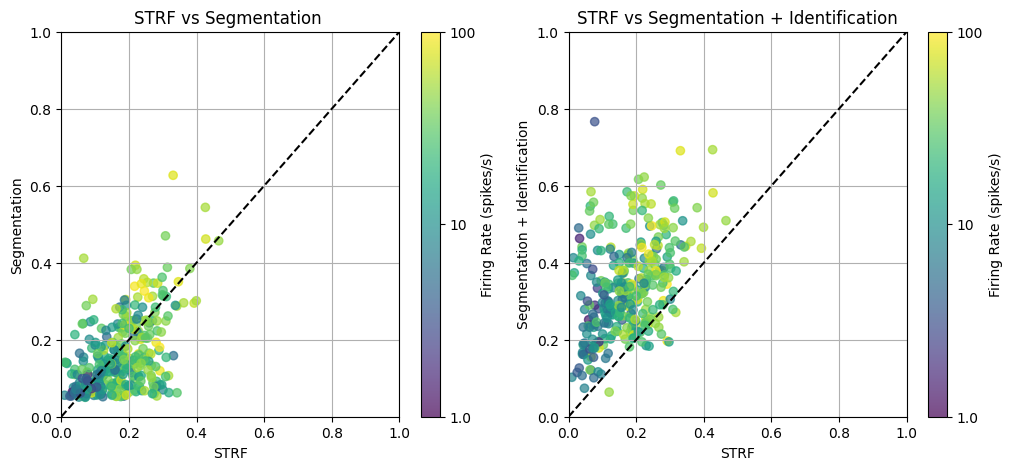

In [36]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(r2STRFs[idx_model]/r2Ceils[idx_model], r2Segs[idx_model]/r2Ceils[idx_model], c = np.log10(rate[idx_model]), cmap ='viridis', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('STRF vs Segmentation ')
plt.xlabel('STRF')
plt.ylabel('Segmentation')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(r2STRFs[idx_model]/r2Ceils[idx_model], r2segIds[idx_model]/r2Ceils[idx_model], c = np.log10(rate[idx_model]), cmap ='viridis', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('STRF vs Segmentation + Identification')
plt.xlabel('STRF')
plt.ylabel('Segmentation + Identification')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.show()

In [38]:
np.unique(unit_types)

array(['bs', 'ns'], dtype='<U2')

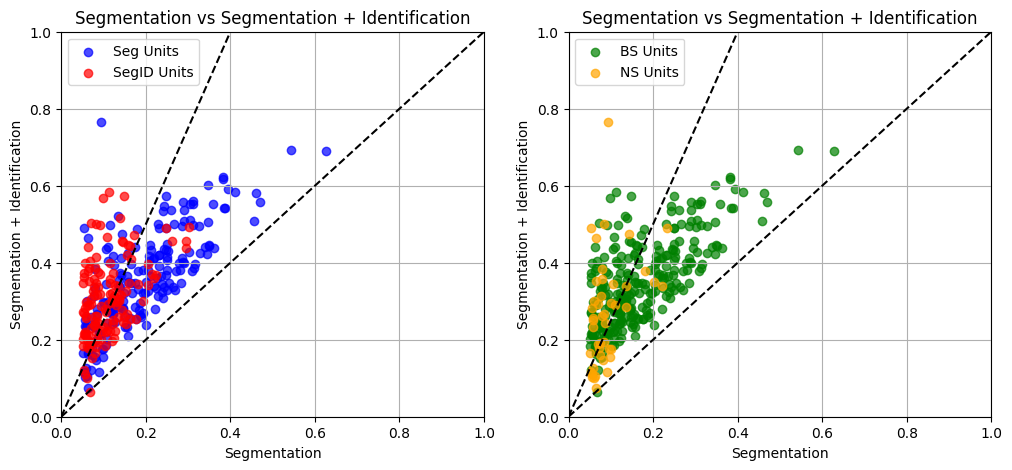

In [40]:
seg_idx = idx_model & (r2STRFs <= 1.2*r2Segs)
segId_idx = idx_model & (r2STRFs > 1.2*r2Segs)

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.scatter(r2Segs[seg_idx]/r2Ceils[seg_idx], r2segIds[seg_idx]/r2Ceils[seg_idx], c = 'blue', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.scatter(r2Segs[segId_idx]/r2Ceils[segId_idx], r2segIds[segId_idx]/r2Ceils[segId_idx], c = 'red', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [0, 2.5], 'k--')
plt.title('Segmentation vs Segmentation + Identification')
plt.xlabel('Segmentation')
plt.ylabel('Segmentation + Identification')
plt.legend(['Seg Units', 'SegID Units'])
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.subplot(1,2,2)
bs_idx = idx_model & (unit_types == 'bs')
ns_idx = idx_model & (unit_types == 'ns')
plt.scatter(r2Segs[bs_idx]/r2Ceils[bs_idx], r2segIds[bs_idx]/r2Ceils[bs_idx], c = 'green', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.scatter(r2Segs[ns_idx]/r2Ceils[ns_idx], r2segIds[ns_idx]/r2Ceils[ns_idx], c = 'orange', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [0, 2.5], 'k--')
plt.title('Segmentation vs Segmentation + Identification')
plt.xlabel('Segmentation')
plt.ylabel('Segmentation + Identification')
plt.legend(['BS Units', 'NS Units'])
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.show()